In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
# from deside.utility import cancer_types, check_dir, read_marker_gene, calculate_rmse, set_fig_style
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set
from deside.utility.compare import read_and_merge_result, cal_gene_signature_score
from deside.utility import (ExpObj, set_fig_style, sorted_cell_types, read_marker_gene,
                            get_corr, check_dir, cancer_types, get_ccc, 
                            read_cancer_purity, calculate_rmse, print_df)
# sns.set(font_scale=2)
# sns.set_style("white")
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-06-20 18:08:44.768609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'
dataset_dir = r'../datasets/'
fig_dir = './fig3/'
model_evaluation_dir = '../tables_model_evaluation/'

## Evaluate the performance based on TCGA and CPE across different algorithms 

### Merge predicted cell proportions across different cancer types for each algorithm

In [3]:
merged_dir = os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'merged_result')
cancer_purity_file_path = os.path.join(dataset_dir, 'cancer_purity', 'cancer_purity.csv')
tcga_sample_id2cancer_type_file_path = os.path.join(dataset_dir, 'TCGA', 'tpm', 'tcga_sample_id2cancer_type_with_ov.csv')
if os.path.exists(merged_dir):
    shutil.rmtree(merged_dir)
check_dir(merged_dir)

In [4]:
algos = ['DeSide', 'DeSide_softmax', 'CIBERSORTx_HNSCC', 'EPIC_TRef', 'Scaden_ascites', 'Kassandra_self', 'CIBERSORTx_LUAD', 'Scaden_D1D2', 'MuSiC_LUAD']
algo2merged_file_path = {i: os.path.join(merged_dir, f'{i}_pred_cell_prop.csv') for i in algos}
algo2merged_file_path

{'DeSide': '../tables_model_evaluation/predicted_cell_fractions/merged_result/DeSide_pred_cell_prop.csv',
 'DeSide_softmax': '../tables_model_evaluation/predicted_cell_fractions/merged_result/DeSide_softmax_pred_cell_prop.csv',
 'CIBERSORTx_HNSCC': '../tables_model_evaluation/predicted_cell_fractions/merged_result/CIBERSORTx_HNSCC_pred_cell_prop.csv',
 'EPIC_TRef': '../tables_model_evaluation/predicted_cell_fractions/merged_result/EPIC_TRef_pred_cell_prop.csv',
 'Scaden_ascites': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Scaden_ascites_pred_cell_prop.csv',
 'Kassandra_self': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Kassandra_self_pred_cell_prop.csv',
 'CIBERSORTx_LUAD': '../tables_model_evaluation/predicted_cell_fractions/merged_result/CIBERSORTx_LUAD_pred_cell_prop.csv',
 'Scaden_D1D2': '../tables_model_evaluation/predicted_cell_fractions/merged_result/Scaden_D1D2_pred_cell_prop.csv',
 'MuSiC_LUAD': '../tables_model_evaluation/predict

In [5]:
pred_dir = './predicted_cell_prop'
algo2raw_result_dir = {
    'CIBERSORTx_HNSCC' : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'CIBERSORT_result', 'HNSCC_ref'),
    'CIBERSORTx_LUAD'  : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'CIBERSORT_result', 'LUAD_ref'),
    'DeSide'           : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'DeSide_result', 'sigmoid_20231110_003'),
    'DeSide_softmax'   : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'DeSide_result', 'softmax_20231110_005'),
    'EPIC_TRef'        : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'EPIC_1125', 'EPIC_self_sig_and_ct', 'data'),
    'Scaden_ascites'   : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Scaden_result', 'human_ascites_local'),
    'Scaden_D1D2'      : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Scaden_result', 'D1D2'),
    'Kassandra_self'   : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'Kassandra_result'),
    'MuSiC_LUAD'       : os.path.join(model_evaluation_dir, 'predicted_cell_fractions', 'MuSiC_result')
}
algo2raw_result_dir

{'CIBERSORTx_HNSCC': '../tables_model_evaluation/predicted_cell_fractions/CIBERSORT_result/HNSCC_ref',
 'CIBERSORTx_LUAD': '../tables_model_evaluation/predicted_cell_fractions/CIBERSORT_result/LUAD_ref',
 'DeSide': '../tables_model_evaluation/predicted_cell_fractions/DeSide_result/sigmoid_20231110_003',
 'DeSide_softmax': '../tables_model_evaluation/predicted_cell_fractions/DeSide_result/softmax_20231110_005',
 'EPIC_TRef': '../tables_model_evaluation/predicted_cell_fractions/EPIC_1125/EPIC_self_sig_and_ct/data',
 'Scaden_ascites': '../tables_model_evaluation/predicted_cell_fractions/Scaden_result/human_ascites_local',
 'Scaden_D1D2': '../tables_model_evaluation/predicted_cell_fractions/Scaden_result/D1D2',
 'Kassandra_self': '../tables_model_evaluation/predicted_cell_fractions/Kassandra_result',
 'MuSiC_LUAD': '../tables_model_evaluation/predicted_cell_fractions/MuSiC_result'}

In [6]:
cell_type2subtypes = {'B Cells': ['Non-plasma B cells', 'Plasma B cells'],
                      'CD4 T': ['CD4 T'], 'CD8 T': ['CD8 T (GZMK high)', 'CD8 T effector'],
                      'DC': ['DC'], 'Endothelial Cells': ['Endothelial Cells'],
                      'Cancer Cells': ['Cancer Cells'],
                      'Fibroblasts': ['CAFs', 'Myofibroblasts'], 'Macrophages': ['Macrophages'],
                      'Mast Cells': ['Mast Cells'], 'NK': ['NK'], 'Neutrophils': ['Neutrophils'],
                      'Double-neg-like T': ['Double-neg-like T'], 'Monocytes': ['Monocytes']}
all_cell_types = sorted([i for v in cell_type2subtypes.values() for i in v])
all_cell_types

['CAFs',
 'CD4 T',
 'CD8 T (GZMK high)',
 'CD8 T effector',
 'Cancer Cells',
 'DC',
 'Double-neg-like T',
 'Endothelial Cells',
 'Macrophages',
 'Mast Cells',
 'Monocytes',
 'Myofibroblasts',
 'NK',
 'Neutrophils',
 'Non-plasma B cells',
 'Plasma B cells']

In [7]:
sorted_cell_type_list2 = ['B Cells', 'CD4 T', 'CD8 T', 'Cancer Cells', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages', 'Mast Cells', 'NK', 'Neutrophils']
sorted_cell_type_list3 = ['B Cells', 'Cancer Cells', 'Endothelial Cells', 'Fibroblasts', 'Mast Cells', 'T Cells', 'Myeloid cells']

In [8]:
# mapping cell type names
ct_without_neutrophils = [i for i in sorted_cell_type_list2 if i != 'Neutrophils']
algo2cell_type_name_mapping = {
        'CIBERSORTx_HNSCC': {'B cell': 'B Cells', 'T cells CD4': 'CD4 T', 'T cells CD8': 'CD8 T', 'Dendritic': 'DC',
                            'Malignant': 'Cancer Cells', 'Endothelial': 'Endothelial Cells',
                            'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'Mast': 'Mast Cells',
                            },
        'CIBERSORTx_LUAD': dict(zip(ct_without_neutrophils, ct_without_neutrophils)),
        'DeSide': dict(zip(all_cell_types, all_cell_types)),
        'DeSide_softmax': dict(zip(all_cell_types, all_cell_types)),
        'EPIC_TRef': {'B.cells': 'B Cells', 'CD4.T': 'CD4 T', 'CD8.T': 'CD8 T',
                      'otherCells': 'Cancer Cells', 'Endothelial.Cells': 'Endothelial Cells',
                      'Fibroblasts': 'Fibroblasts',  'NK': 'NK', 'Macrophages': 'Macrophages',
                      },
        'Scaden_ascites': {'CD4Tcells': 'CD4 T', 'CD8Tcells': 'CD8 T', 'Carcinoma': 'Cancer Cells',
                           'DC': 'DC', 'Fibroblast': 'Fibroblasts', 'NK': 'NK',
                          },
        'Scaden_D1D2': dict(zip(all_cell_types, all_cell_types)),
        'Kassandra_self': {'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'},
        'MuSiC_LUAD': dict(zip(sorted_cell_type_list3, sorted_cell_type_list3)),
}

In [9]:
for algo, m_fp in algo2merged_file_path.items():
    print(f'Merge the results of {algo}...')
    read_and_merge_result(raw_result_dir=algo2raw_result_dir[algo], algo=algo,
                          result_file_path=algo2merged_file_path[algo],
                          cell_type_name_mapping=algo2cell_type_name_mapping[algo],
                          tcga_sample2cancer_type_file_path=tcga_sample_id2cancer_type_file_path)

Merge the results of DeSide...
Merge the results of DeSide_softmax...
Merge the results of CIBERSORTx_HNSCC...
Merge the results of EPIC_TRef...
Merge the results of Scaden_ascites...
Merge the results of Kassandra_self...
Merge the results of CIBERSORTx_LUAD...
Merge the results of Scaden_D1D2...
Merge the results of MuSiC_LUAD...


In [10]:
tcga_sample_id2cancer_type = pd.read_csv(tcga_sample_id2cancer_type_file_path, index_col=0)
print(tcga_sample_id2cancer_type.shape)
tcga_sample_id2cancer_type.head(2)

(8120, 1)


,cancer_type
TCGA-OR-A5LO-01A,ACC
TCGA-P6-A5OG-01A,ACC


In [11]:
cpe = read_cancer_purity(cancer_purity_file_path=cancer_purity_file_path, sample_names=tcga_sample_id2cancer_type.index.to_list())
print(cpe.shape)
cpe.head(2)

(7872, 7)


,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,Unnamed: 7
Sample ID,,,,,,,
TCGA-02-0047-01A,GBM,0.7648,0.7,NaN,0.925,0.8266,NaN
TCGA-DU-8163-01A,LGG,0.8604,NaN,0.8678,0.750,0.8210,NaN


In [12]:
tcga_cpe_intersection = tcga_sample_id2cancer_type.merge(cpe.loc[:, ['CPE']], left_index=True, right_index=True)
tcga_cpe_intersection.index = tcga_cpe_intersection.index.map(lambda x: x.replace('.', '-'))
print(tcga_cpe_intersection.shape)
tcga_cpe_intersection.head(2)

(7872, 2)


,cancer_type,CPE
TCGA-OR-A5LO-01A,ACC,0.9954
TCGA-P6-A5OG-01A,ACC,0.4616


In [13]:
algo_new_names = {
    'DeSide': 'DeSide \n (D1D2)', 'DeSide_softmax': 'DeSide \n (softmax)', 'CIBERSORTx_HNSCC': 'CIBERSORTx \n (HNSCC)', 'CIBERSORTx_LUAD': 'CIBERSORTx \n (LUAD)', 
    'EPIC_TRef': 'EPIC \n (TRef)', 'Scaden_ascites': 'Scaden \n (Ascites)', 
    'Scaden_D1D2': 'Scaden \n (D1D2)', 'Kassandra_self': 'Kassandra \n (Default)', 'MuSiC_LUAD': 'MuSiC \n (LUAD)',
}

In [14]:
def compare_y_y_pred(y_true: pd.Series, y_pred: pd.Series, cancer_type='', algo=''):
    """
    Calculate correlation, RMSM, and CCC between y and y_pred

    :param y_true: CPE

    :param y_pred: this file contains the predicted value of y

    :param cancer_type: cancer type

    :param algo: algorithm name

    :return: correlatin, RMSE, CCC
    """
    corr = 0
    rmse = 0
    ccc = 0
    corr = get_corr(y_pred, y_true)
    rmse = calculate_rmse(y_true=pd.DataFrame(y_true), y_pred=pd.DataFrame(y_pred))
    ccc = get_ccc(y_pred.values, y_true.values)

    return corr, rmse, ccc

In [15]:
cancer_types += ['OV']

In [16]:
metrics_value = {}
cancer_types2 = [i for i in cancer_types if i != 'PAAD']

In [17]:
# y_true = ReadH5AD(y_true_file_path).get_cell_fraction()
for ct in cancer_types2:
    current_cancer_type = ct
    print(f'Dealing with {current_cancer_type}...')
    current_cpe = tcga_cpe_intersection.loc[tcga_cpe_intersection['cancer_type'] == current_cancer_type, 'CPE']
    for algo in algos:
        print(f'- Dealing with {algo}')
        current_algo = algo
        y_pred_file_path = algo2merged_file_path[current_algo]
        y_pred = pd.read_csv(y_pred_file_path, index_col='sample_id').loc[:, 'Cancer Cells'].copy()
        
        common_sample_id = list(set([i for i in y_pred.index if i in current_cpe.index]))
        if len(common_sample_id) > 0:
            # print(len(common_sample_id))
            current_cpe = current_cpe.loc[common_sample_id].copy()
            y_pred = y_pred.loc[common_sample_id].copy()
            assert np.all(current_cpe.index == y_pred.index)
            corr, rmse, ccc = compare_y_y_pred(y_pred=y_pred, y_true=current_cpe, cancer_type=current_cancer_type, algo=algo_new_names[current_algo])
            metrics_value[(current_algo, current_cancer_type)] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}
        else:
            print(f'>> {algo}')

Dealing with ACC...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with BLCA...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with BRCA...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with GBM...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassa

/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Dealing with HNSC...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with LGG...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with LIHC...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with LUAD...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kass

/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with KIRP...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with LUSC...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD
- Dealing with Scaden_D1D2
- Dealing with MuSiC_LUAD
Dealing with READ...
- Dealing with DeSide
- Dealing with DeSide_softmax
- Dealing with CIBERSORTx_HNSCC
- Dealing with EPIC_TRef
- Dealing with Scaden_ascites
- Dealing with Kassandra_self
- Dealing with CIBERSORTx_LUAD


In [18]:
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.index.names = ['algorithm', 'cancer_type']
print(metrics_value_df.shape)
metrics_value_df.head(2)

(169, 3)


,,corr,rmse,ccc
algorithm,cancer_type,,,
DeSide,ACC,0.784109,0.134205,0.555562
DeSide_softmax,ACC,0.818602,0.146500,0.547905


In [19]:
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cancer_cell_prop_vs_cpe.csv'), float_format='%.3f')

#### Bar plot to compare CCC value across 5 different algorithms 
- Predicted cell proportions of cancer cells vs CPE (Fig. S3-S4)

In [20]:
ccc_values = pd.read_csv(os.path.join(fig_dir, 'pred_cancer_cell_prop_vs_cpe.csv'))
print(ccc_values.shape)
ccc_values.head(2)

(169, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548


In [21]:
ccc_values['algorithm'].unique()

array(['DeSide', 'DeSide_softmax', 'CIBERSORTx_HNSCC', 'EPIC_TRef',
       'Scaden_ascites', 'Kassandra_self', 'CIBERSORTx_LUAD',
       'Scaden_D1D2', 'MuSiC_LUAD'], dtype=object)

In [22]:
ccc_values_6_algo = ccc_values.loc[~ccc_values['algorithm'].isin(['CIBERSORTx_LUAD', 'Scaden_D1D2', 'DeSide_softmax']), :].copy()
print(ccc_values_6_algo.shape)
ccc_values_6_algo.head(2)

(114, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
2,CIBERSORTx_HNSCC,ACC,-0.160,0.893,-0.002


In [23]:
ccc_values_6_algo['cancer_type'].unique()

array(['ACC', 'BLCA', 'BRCA', 'GBM', 'HNSC', 'LGG', 'LIHC', 'LUAD',
       'PRAD', 'CESC', 'COAD', 'KICH', 'KIRC', 'KIRP', 'LUSC', 'READ',
       'THCA', 'UCEC', 'OV'], dtype=object)

In [24]:
cancer_type2ccc_6_algo = ccc_values_6_algo.loc[ccc_values_6_algo['algorithm'] == 'DeSide', ['cancer_type', 'ccc']]
cancer_type2ccc_6_algo = cancer_type2ccc_6_algo.sort_values(by='ccc', ascending=False)
cancer_type2ccc_6_algo.head(2)

,cancer_type,ccc
126,LUSC,0.781
63,LUAD,0.775


In [25]:
color_5 = [sns.color_palette("Paired")[i] for i in [1, 3, 7, 5, 11, 9]]
sns.color_palette(color_5)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.4980392156862745, 0.0),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

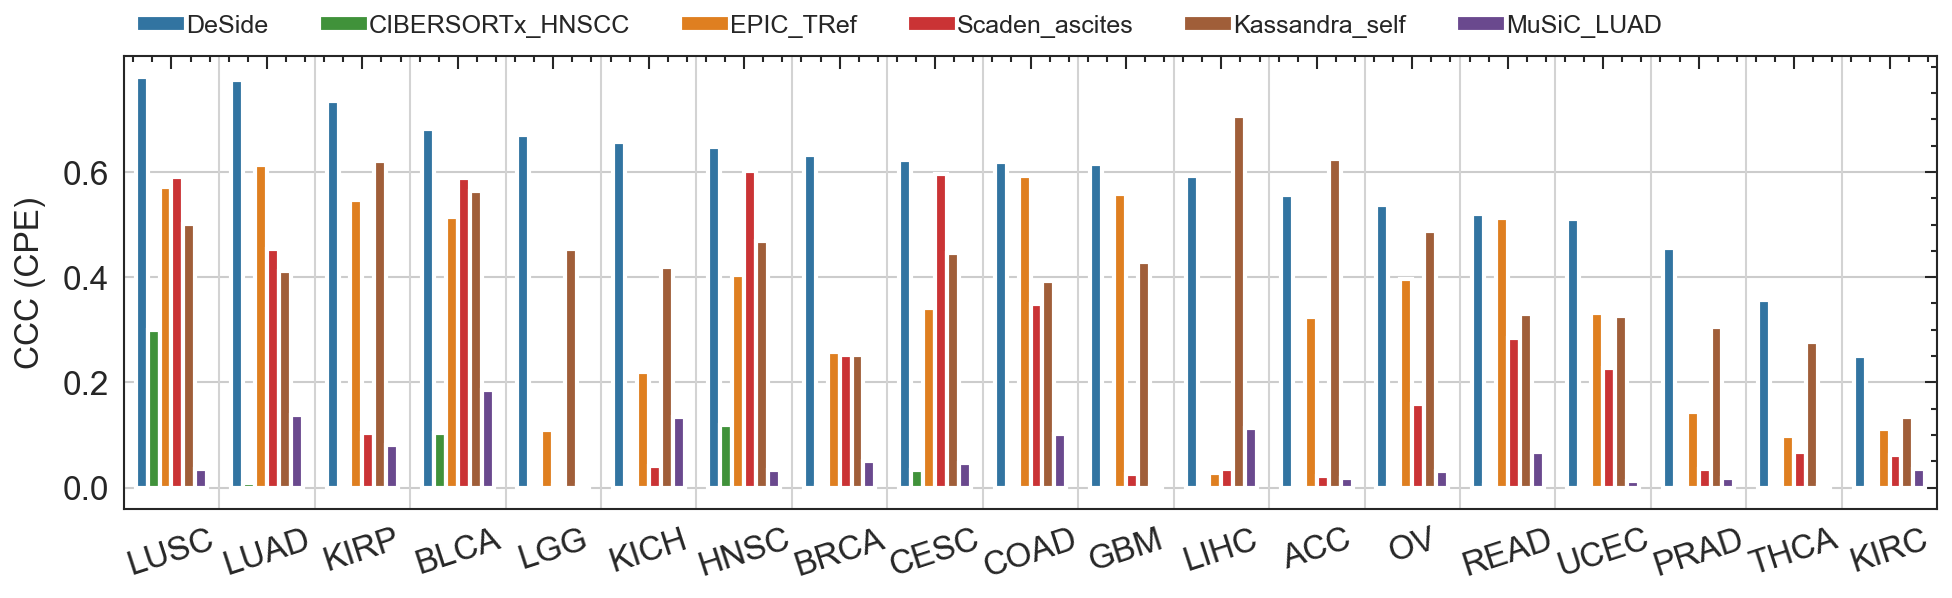

In [26]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(7.8, 2))
width = 0.75
g1 = sns.barplot(data=ccc_values_6_algo, x='cancer_type', y='ccc', hue='algorithm', ax=ax1, width=width, 
                 order=cancer_type2ccc_6_algo['cancer_type'].to_list(), palette=color_5, hue_order=['DeSide', 'CIBERSORTx_HNSCC', 'EPIC_TRef', 'Scaden_ascites', 'Kassandra_self', 'MuSiC_LUAD'])
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.12), ncol=6, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(len(cancer_types)):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(18)
# ax.legend(fontsize=6, loc='best')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
ax1.set_xlabel('')
ax1.set_ylabel('CCC (CPE)')

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_algo_with_music.svg'), dpi=300)

#### Bar plot to compare CCC value across 6 different algorithms 
- Predicted cell proportions of cancer cells vs CPE (Fig. S3-S4)

In [27]:
ccc_values

,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548
2,CIBERSORTx_HNSCC,ACC,-0.160,0.893,-0.002
3,EPIC_TRef,ACC,0.615,0.188,0.325
4,Scaden_ascites,ACC,0.616,0.575,0.022
...,...,...,...,...,...
164,EPIC_TRef,OV,0.436,0.127,0.396
165,Scaden_ascites,OV,0.477,0.193,0.158
166,Kassandra_self,OV,0.681,0.136,0.488
167,Scaden_D1D2,OV,0.720,0.240,0.210


In [28]:
algo_all_eight = ['DeSide', 'DeSide_softmax', 'CIBERSORTx_HNSCC', 'CIBERSORTx_LUAD', 'Scaden_ascites', 'Scaden_D1D2', 'EPIC_TRef', 'Kassandra_self', 'MuSiC_LUAD']
ccc_values_all_eight = ccc_values.loc[ccc_values['algorithm'].isin(algo_all_eight), :].copy()
print(ccc_values_all_eight.shape)
ccc_values_all_eight.head(2)

(169, 5)


,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548


In [29]:
color_pair = [sns.color_palette("Paired")[i] for i in [1, 0, 3, 2, 5, 4, 7, 11, 9]]
sns.color_palette(color_pair)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (1.0, 0.4980392156862745, 0.0),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

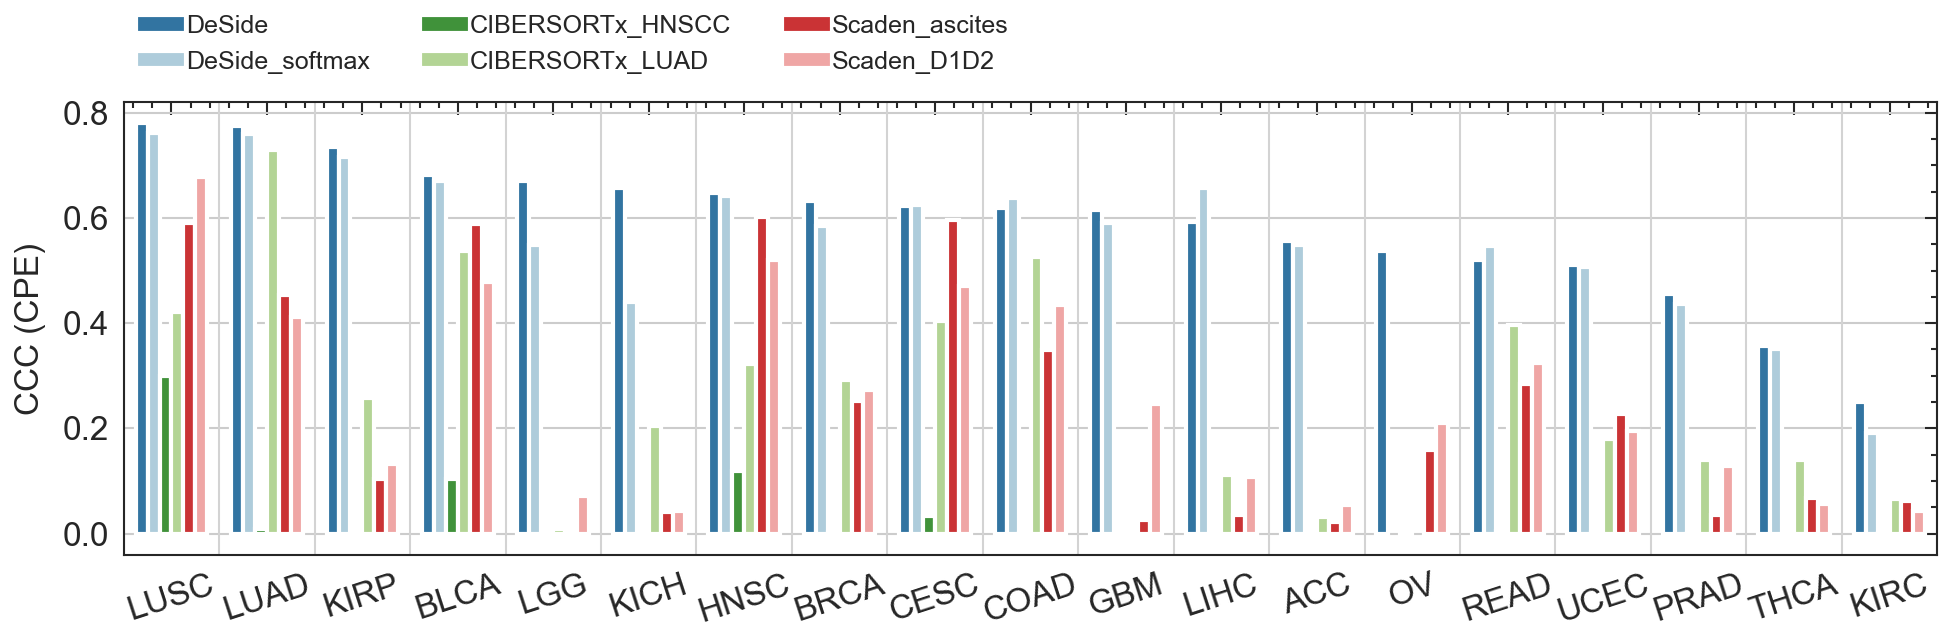

In [30]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(7.8, 2))
width = 0.75
g1 = sns.barplot(data=ccc_values_all_eight.loc[~ccc_values_all_eight['algorithm'].isin(['EPIC_TRef', 'Kassandra_self', 'MuSiC_LUAD'])], x='cancer_type', y='ccc', ax=ax1, 
                 width=width, palette=color_pair[:-3], hue='algorithm', order=cancer_type2ccc_6_algo['cancer_type'].to_list(),
                 hue_order=algo_all_eight[:6])
# g2 = sns.stripplot(data=ccc_values_all_eight, x="algorithm", y="ccc", size=2, color=".3", linewidth=0, order=algo_all_eight)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.22), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(len(cancer_types)):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(18)
# # ax.legend(fontsize=6, loc='best')
# ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
ax1.set_xlabel('')
ax1.set_ylabel('CCC (CPE)')

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_pairwise_barplot_new_scaden_d1d2.svg'), dpi=300)

#### Calculate P-values (Wilcoxon signed-rank test)

In [31]:
ccc_values_all_eight.head(2)

,algorithm,cancer_type,corr,rmse,ccc
0,DeSide,ACC,0.784,0.134,0.556
1,DeSide_softmax,ACC,0.819,0.147,0.548


In [32]:
# Wilcoxon signed-rank test
algo2p_values2 = {}
# ccc_values_all_eight_without_nc = ccc_values_all_eight.loc[~ccc_values_all_eight['cancer_type'].isin(['LGG', 'GBM']), :].copy()
deside_ccc_with_ov = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'DeSide', ['cancer_type', 'ccc']].copy()
deside_ccc_without_ov = ccc_values_all_eight.loc[(ccc_values_all_eight['algorithm'] == 'DeSide') & (ccc_values_all_eight['cancer_type'] != 'OV'), ['cancer_type', 'ccc']].copy()
# print(deside_ccc_with_ov)
for algo in algo_all_eight[2:]:
    _ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == algo, ['cancer_type', 'ccc']].copy()
    if 'OV' in _ccc['cancer_type'].values:
        deside_ccc = deside_ccc_with_ov.copy()
    else:
        deside_ccc = deside_ccc_without_ov.copy()
    # print(deside_ccc, _ccc)
    assert np.all(deside_ccc['cancer_type'].values == _ccc['cancer_type'].values)
    _, _p = stats.wilcoxon(deside_ccc['ccc'], _ccc['ccc'])
    algo2p_values2[algo] = _p
algo2p_values2

{'CIBERSORTx_HNSCC': 3.814697265625e-06,
 'CIBERSORTx_LUAD': 7.62939453125e-06,
 'Scaden_ascites': 3.814697265625e-06,
 'Scaden_D1D2': 3.814697265625e-06,
 'EPIC_TRef': 3.814697265625e-06,
 'Kassandra_self': 9.5367431640625e-05,
 'MuSiC_LUAD': 3.814697265625e-06}

In [33]:
# CIBERSORT_hnscc vs CIBERSORT_luad
cibersort_hnscc_ccc = ccc_values_all_eight.loc[(ccc_values_all_eight['algorithm'] == 'CIBERSORTx_HNSCC') & (ccc_values_all_eight['cancer_type'] != 'OV'), ['cancer_type', 'ccc']].copy()
cibersort_luad_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'CIBERSORTx_LUAD', ['cancer_type', 'ccc']].copy()
assert np.all(cibersort_hnscc_ccc['cancer_type'].values == cibersort_luad_ccc['cancer_type'].values)
_, _p = stats.wilcoxon(cibersort_hnscc_ccc['ccc'], cibersort_luad_ccc['ccc'])
_p

7.62939453125e-06

In [34]:
# Scaden_ascites vs Scaden_simu_bulk
scaden_as_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'Scaden_ascites', ['cancer_type', 'ccc']].copy()
scaden_si_ccc = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == 'Scaden_D1D2', ['cancer_type', 'ccc']].copy()
assert np.all(scaden_as_ccc['cancer_type'].values == scaden_si_ccc['cancer_type'].values)
_, _p = stats.wilcoxon(scaden_as_ccc['ccc'], scaden_si_ccc['ccc'])
_p

0.2934989929199219

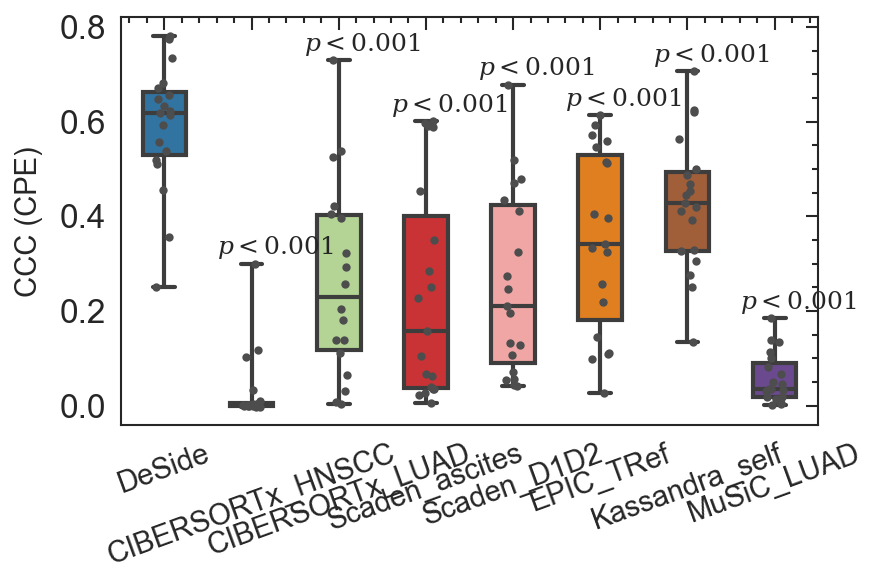

In [35]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(3., 1.8))
width = 0.5
g1 = sns.boxplot(data=ccc_values_all_eight, x='algorithm', y='ccc', ax=ax1, width=width, order=algo_all_eight[0:1] + algo_all_eight[2:], whis=[0, 100], palette=color_pair[0:1] + color_pair[2:])
g2 = sns.stripplot(data=ccc_values_all_eight, x="algorithm", y="ccc", ax=ax1, size=2, color=".3", linewidth=0, order=algo_all_eight[0:1] + algo_all_eight[2:])
# g1.set_xticklabels(fontsize=6)
for i in range(7):
    _current_algo = algo_all_eight[i+2]
    y_max = ccc_values_all_eight.loc[ccc_values_all_eight['algorithm'] == _current_algo, ['ccc']].max()
    p_value = algo2p_values2[_current_algo]
    if p_value < 0.001:
        plt.text(i+0.6, y_max + 0.02, '$p<0.001$'.format(p_value), fontsize=6)
    else:
        plt.text(i+0.6, y_max + 0.02, '$p={:.3f}$'.format(p_value), fontsize=6)
        
for item in g1.get_xticklabels():
    item.set_rotation(20)
    item.set_fontsize(7)
ax1.set_xlabel('')
ax1.set_ylabel('CCC (CPE)', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_algo_pairwise_boxplot_new_scaden_d1d2_add_music.svg'), dpi=300)

In [36]:
ccc_values_all_eight.groupby('algorithm').median()

/var/folders/qj/vrg9kck17g3bhjcg9bf6yk8m0000gp/T/ipykernel_50301/2703772420.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ccc_values_all_eight.groupby('algorithm').median()


,corr,rmse,ccc
algorithm,,,
CIBERSORTx_HNSCC,0.0530,0.7340,0.0010
CIBERSORTx_LUAD,0.6285,0.2745,0.2305
DeSide,0.7220,0.1140,0.6180
DeSide_softmax,0.7285,0.1165,0.5880
EPIC_TRef,0.4790,0.1720,0.3410
Kassandra_self,0.7100,0.1920,0.4290
MuSiC_LUAD,0.3070,0.5210,0.0350
Scaden_D1D2,0.6900,0.2640,0.2100
Scaden_ascites,0.5950,0.2170,0.1580


## Comparing with CPE across 19 cancer types

### Ascites-OV

In [37]:
ds = 'OV-ascites'
ccc_scaden_scaden_simu_ascites = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-Scaden_scaden_ascites_OV-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_ascites.index.name = 'cancer_type'
ccc_scaden_scaden_simu_ascites['model'] = f'Scaden_{ds}'
print(ccc_scaden_scaden_simu_ascites.shape)
ccc_scaden_scaden_simu_ascites.head(2)

(19, 4)


,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.616410,0.574710,0.021978,Scaden_OV-ascites
BLCA,0.667762,0.134578,0.589109,Scaden_OV-ascites


In [38]:
ds = 'D1D2'
deside_d1d2 = pd.read_csv(f'./data_in_figures/results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-DeSide_D1D2-metrics.csv', index_col=0)
deside_d1d2.index.name = 'cancer_type'
deside_d1d2['model'] = f'DeSide_{ds}'
print(deside_d1d2.shape)
deside_d1d2.head(2)

(19, 4)


,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.784109,0.134205,0.555562,DeSide_D1D2
BLCA,0.722290,0.130579,0.681812,DeSide_D1D2


In [39]:
ds = 'OV-ascites'
epic_ov_ascites = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-EPIC_scaden_ascites_OV-metrics.csv', index_col=0)
epic_ov_ascites.index.name = 'cancer_type'
epic_ov_ascites['model'] = f'EPIC_{ds}'
print(epic_ov_ascites.shape)
epic_ov_ascites.head(2)

(19, 4)


,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.326491,0.159738,0.275909,EPIC_OV-ascites
BLCA,0.578131,0.296012,0.380665,EPIC_OV-ascites


In [40]:
# ds = 'OV-ascites'
cibersortx_ov_ascites = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-CIBERSORTX_scaden_ascites_OV-metrics.csv', index_col=0)
cibersortx_ov_ascites.index.name = 'cancer_type'
cibersortx_ov_ascites['model'] = f'CIBERSORTx_{ds}'
print(cibersortx_ov_ascites.shape)
cibersortx_ov_ascites.head(2)

(19, 4)


,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.492988,0.641299,0.030736,CIBERSORTx_OV-ascites
BLCA,0.672304,0.200686,0.523823,CIBERSORTx_OV-ascites


In [41]:
# ds = 'OV-ascites'
music_ov_ascites = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-MuSiC_scaden_ascites_OV-metrics.csv', index_col=0)
music_ov_ascites.index.name = 'cancer_type'
music_ov_ascites['model'] = f'MuSiC_{ds}'
print(music_ov_ascites.shape)
music_ov_ascites.head(2)

(19, 4)


,corr,rmse,ccc,model
cancer_type,,,,
ACC,-0.086091,0.609905,-0.011498,MuSiC_OV-ascites
BLCA,0.297271,0.584658,0.043680,MuSiC_OV-ascites


### Geistlinger2020_Ovarian_3CA

In [42]:
# ds = f'Scaden-simu({ds_ct})'
ds_ct = 'OV'
ds_name = 'Geistlinger2020_Ovarian_3CA'
algo = 'Scaden'
ccc_scaden_scaden_simu_ov = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_ov.index.name = 'cancer_type'
ccc_scaden_scaden_simu_ov['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_ov.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.753121,0.636276,0.028326,Scaden_OV
BLCA,0.688139,0.279772,0.273956,Scaden_OV


In [43]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_ov = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_ov.index.name = 'cancer_type'
ccc_epic_ov['model'] = f'{algo}_{ds_ct}'
ccc_epic_ov.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.404948,0.235526,0.200652,EPIC_OV
BLCA,0.670849,0.202525,0.557796,EPIC_OV


In [44]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_ov = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_ov.index.name = 'cancer_type'
ccc_music_ov['model'] = f'{algo}_{ds_ct}'
ccc_music_ov.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.748613,0.562314,0.049968,MuSiC_OV
BLCA,0.637292,0.367766,0.235947,MuSiC_OV


In [45]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_ov = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_ov.index.name = 'cancer_type'
ccc_cibersortx_ov['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_ov.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.819872,0.362207,0.169484,CIBERSORTx_OV
BLCA,0.695465,0.180340,0.594858,CIBERSORTx_OV


### luad_kim_05

In [46]:
# ds = f'Scaden-simu({ds_ct})'
ds_ct = 'LUAD'
ds_name = 'luad_kim_05'
algo = 'Scaden'
ccc_scaden_scaden_simu_luad = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_luad.index.name = 'cancer_type'
ccc_scaden_scaden_simu_luad['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_luad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.661034,0.682469,0.014891,Scaden_LUAD
BLCA,0.686515,0.213297,0.431247,Scaden_LUAD


In [47]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_luad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_luad.index.name = 'cancer_type'
ccc_epic_luad['model'] = f'{algo}_{ds_ct}'
ccc_epic_luad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,-0.039375,0.553432,-0.007890,EPIC_LUAD
BLCA,0.200747,0.619265,0.031505,EPIC_LUAD


In [48]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_luad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_luad.index.name = 'cancer_type'
ccc_music_luad['model'] = f'{algo}_{ds_ct}'
ccc_music_luad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.132221,0.583144,0.018131,MuSiC_LUAD
BLCA,0.486618,0.408787,0.185138,MuSiC_LUAD


In [49]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_luad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_luad.index.name = 'cancer_type'
ccc_cibersortx_luad['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_luad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,-0.163530,0.894662,-0.000747,CIBERSORTx_LUAD
BLCA,0.526199,0.376479,0.201367,CIBERSORTx_LUAD


### prad_cheng_08

In [50]:
# ds = f'Scaden-simu({ds_ct})'
ds_ct = 'PRAD'
ds_name = 'prad_cheng_08'
algo = 'Scaden'
ccc_scaden_scaden_simu_prad = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_prad.index.name = 'cancer_type'
ccc_scaden_scaden_simu_prad['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_prad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.842887,0.562532,0.051092,Scaden_PRAD
BLCA,0.513162,0.552590,0.053106,Scaden_PRAD


In [51]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_prad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_prad.index.name = 'cancer_type'
ccc_epic_prad['model'] = f'{algo}_{ds_ct}'
ccc_epic_prad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.105442,0.453070,0.027166,EPIC_PRAD
BLCA,0.318811,0.487921,0.100320,EPIC_PRAD


In [52]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_prad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_prad.index.name = 'cancer_type'
ccc_music_prad['model'] = f'{algo}_{ds_ct}'
ccc_music_prad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.245725,0.882351,0.001860,MuSiC_PRAD
BLCA,0.331118,0.675287,0.019643,MuSiC_PRAD


In [53]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_prad = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_prad.index.name = 'cancer_type'
ccc_cibersortx_prad['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_prad.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.072216,0.893776,0.000382,CIBERSORTx_PRAD
BLCA,0.445409,0.624746,0.037718,CIBERSORTx_PRAD


### gbm_abdelfattah_12

In [54]:
# ds = f'Scaden-simu({ds_ct})'
ds_ct = 'GBM'
ds_name = 'gbm_abdelfattah_12'
algo = 'Scaden'
ccc_scaden_scaden_simu_gbm = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_gbm.index.name = 'cancer_type'
ccc_scaden_scaden_simu_gbm['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_gbm.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.796797,0.662687,0.028036,Scaden_GBM
BLCA,0.549931,0.588064,0.028084,Scaden_GBM


In [55]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_gbm = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_gbm.index.name = 'cancer_type'
ccc_epic_gbm['model'] = f'{algo}_{ds_ct}'
ccc_epic_gbm.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.461102,0.332272,0.180020,EPIC_GBM
BLCA,0.499565,0.509064,0.148567,EPIC_GBM


In [56]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_gbm = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_gbm.index.name = 'cancer_type'
ccc_music_gbm['model'] = f'{algo}_{ds_ct}'
ccc_music_gbm.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.656152,0.594783,0.037613,MuSiC_GBM
BLCA,0.549348,0.576822,0.046703,MuSiC_GBM


In [57]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_gbm = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_gbm.index.name = 'cancer_type'
ccc_cibersortx_gbm['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_gbm.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.659423,0.664402,0.037216,CIBERSORTx_GBM
BLCA,0.246789,0.714815,0.010058,CIBERSORTx_GBM


### HNSCC_Kurten2021_3CA

In [58]:
# ds = f'Scaden-simu({ds_ct})'
ds_ct = 'HNSCC'
ds_name = 'HNSCC_Kurten2021_3CA'
algo = 'Scaden'
ccc_scaden_scaden_simu_hnscc = pd.read_csv(f'./data_in_figures/merged_pred_results_scaden_diff_ref/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_hnscc.index.name = 'cancer_type'
ccc_scaden_scaden_simu_hnscc['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_hnscc.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.523127,0.757459,0.012077,Scaden_HNSCC
BLCA,0.346453,0.433900,0.066359,Scaden_HNSCC


In [59]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_hnscc = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_hnscc.index.name = 'cancer_type'
ccc_epic_hnscc['model'] = f'{algo}_{ds_ct}'
ccc_epic_hnscc.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.415825,0.174939,0.311203,EPIC_HNSCC
BLCA,0.679546,0.178571,0.594321,EPIC_HNSCC


In [60]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_hnscc = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_hnscc.index.name = 'cancer_type'
ccc_music_hnscc['model'] = f'{algo}_{ds_ct}'
ccc_music_hnscc.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,0.349917,0.842674,0.004957,MuSiC_HNSCC
BLCA,0.320267,0.491330,0.069185,MuSiC_HNSCC


In [61]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_hnscc = pd.read_csv(f'./data_in_figures/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_HNSCC_CIBERSORTX_example-metrics.csv', index_col=0)
ccc_cibersortx_hnscc.index.name = 'cancer_type'
ccc_cibersortx_hnscc['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_hnscc.head(2)

,corr,rmse,ccc,model
cancer_type,,,,
ACC,-0.159402,0.892646,-0.001656,CIBERSORTx_HNSCC
BLCA,0.192214,0.387621,0.102814,CIBERSORTx_HNSCC


### Comparison

In [62]:
ccc_all = pd.concat([
    # ccc_deside_deside_simu_ascites, ccc_deside_scaden_simu_ascites, ccc_scaden_scaden_simu_ascites,
    ccc_scaden_scaden_simu_luad,    ccc_epic_luad,   ccc_music_luad,   ccc_cibersortx_luad,
    ccc_scaden_scaden_simu_gbm,     ccc_epic_gbm,    ccc_music_gbm,    ccc_cibersortx_gbm,
    ccc_scaden_scaden_simu_prad,    ccc_epic_prad,   ccc_music_prad,   ccc_cibersortx_prad,
    ccc_scaden_scaden_simu_ov,      ccc_epic_ov,     ccc_music_ov,     ccc_cibersortx_ov,
    ccc_scaden_scaden_simu_ascites, epic_ov_ascites, music_ov_ascites, cibersortx_ov_ascites,
    ccc_scaden_scaden_simu_hnscc,   ccc_epic_hnscc,  ccc_music_hnscc,  ccc_cibersortx_hnscc,
    deside_d1d2])
ccc_all.reset_index(inplace=True)
ccc_all.sort_values(by='ccc', ascending=False, inplace=True)
print(ccc_all.shape)
ccc_all.head(2)

(475, 5)


,cancer_type,corr,rmse,ccc,model
469,LUSC,0.794992,0.101592,0.780789,DeSide_D1D2
468,LUAD,0.782562,0.095784,0.774914,DeSide_D1D2


In [63]:
ccc_all['model'].unique()

array(['DeSide_D1D2', 'Scaden_LUAD', 'EPIC_OV', 'Scaden_OV-ascites',
       'CIBERSORTx_OV', 'EPIC_HNSCC', 'EPIC_OV-ascites',
       'CIBERSORTx_OV-ascites', 'CIBERSORTx_LUAD', 'Scaden_HNSCC',
       'CIBERSORTx_PRAD', 'Scaden_GBM', 'CIBERSORTx_GBM', 'Scaden_OV',
       'EPIC_PRAD', 'CIBERSORTx_HNSCC', 'MuSiC_HNSCC', 'MuSiC_OV',
       'MuSiC_LUAD', 'EPIC_GBM', 'Scaden_PRAD', 'MuSiC_GBM',
       'MuSiC_OV-ascites', 'MuSiC_PRAD', 'EPIC_LUAD'], dtype=object)

In [64]:
color_2 = [sns.color_palette("Paired")[i] for i in [1, 7, 3, 5, 9]]  #  [1, 0, 3, 2, 5, 4, 7, 11, 9]
sns.color_palette(color_2)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

In [65]:
color_2 = [sns.color_palette("tab10")[i] for i in range(5)]
sns.color_palette(color_2)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [66]:
fig_dir = './fig3/'
check_dir(fig_dir)
cancer_types = ccc_all['cancer_type'].unique()

In [67]:
cancer_types

array(['LUSC', 'LUAD', 'KIRP', 'BLCA', 'LGG', 'KICH', 'HNSC', 'BRCA',
       'CESC', 'COAD', 'GBM', 'LIHC', 'ACC', 'OV', 'READ', 'UCEC', 'PRAD',
       'KIRC', 'THCA'], dtype=object)

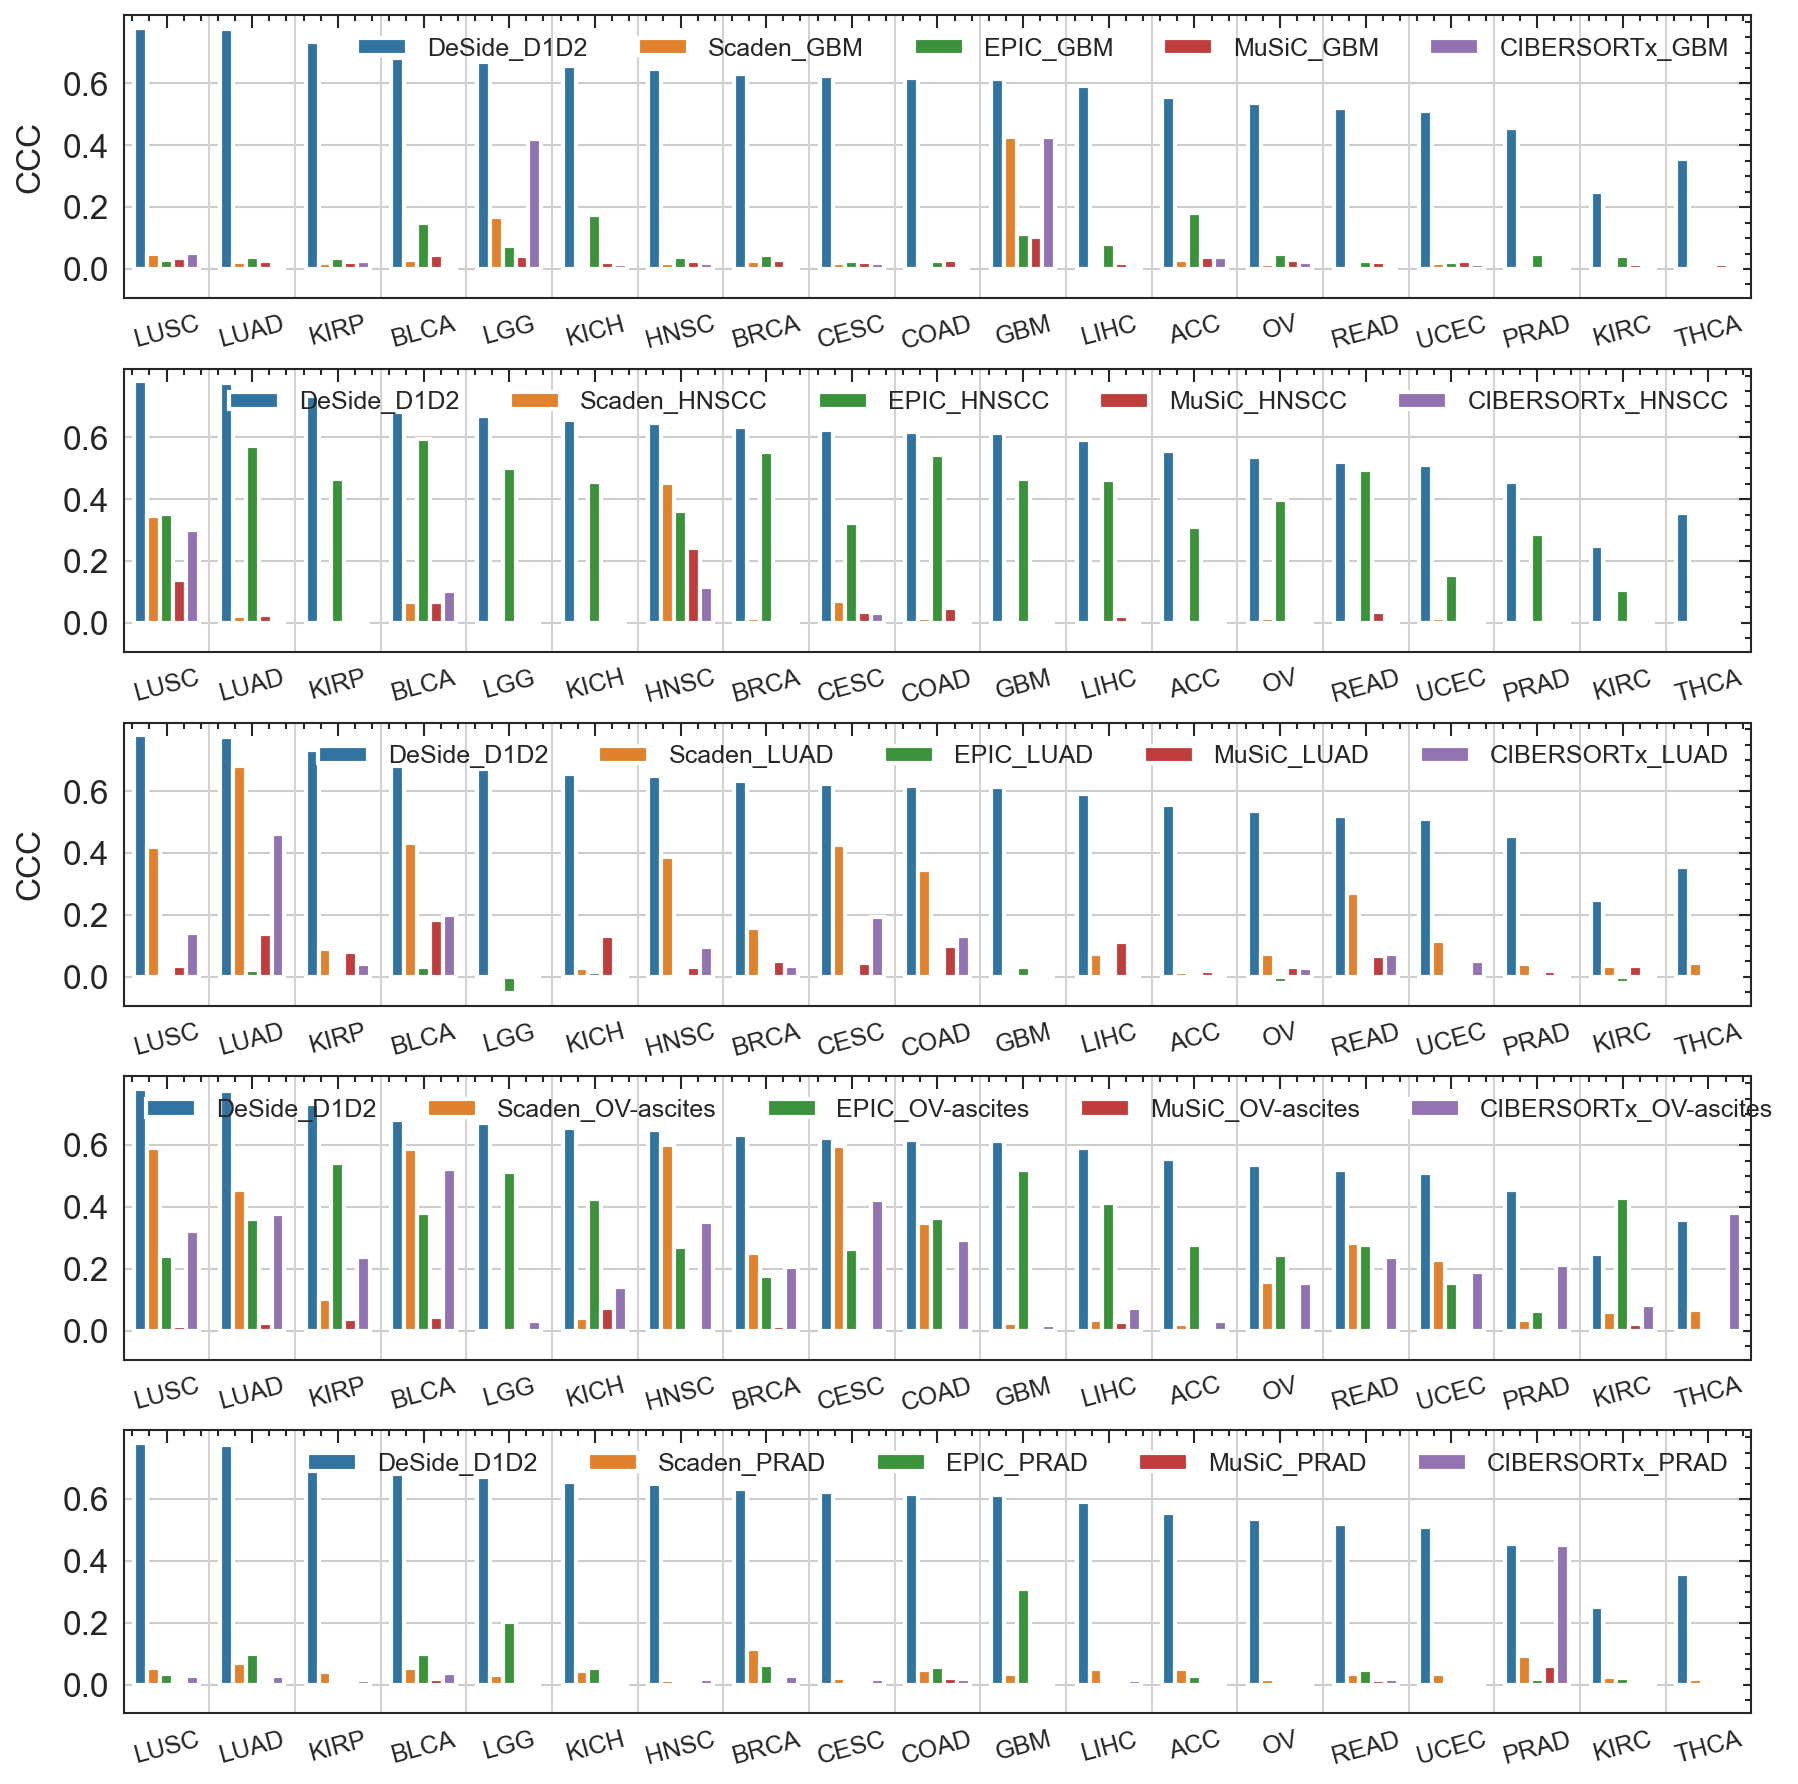

In [68]:
fig, axes = plt.subplots(figsize=(7, 7.5), nrows=5, ncols=1, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g1 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m1), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m1)
g1.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[0].grid(axis='y')
for _x in range(19):
    axes[0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[0].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[0].set_xlabel('')
axes[0].set_ylabel('CCC')

ct = 'HNSCC'
m2 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g2 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m2), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[1], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m2)
g2.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[1].grid(axis='y')
for _x in range(19):
    axes[1].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g2.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[1].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

ct = 'LUAD'
m3 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g3 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m3), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[2], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m3)
g3.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[2].grid(axis='y')
for _x in range(19):
    axes[2].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g3.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[2].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[2].set_xlabel('')
axes[2].set_ylabel('CCC')

ct = 'OV-ascites'
m4 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g4 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m4), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[3], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m4)
g4.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[3].grid(axis='y')
for _x in range(19):
    axes[3].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g4.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[3].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[3].set_xlabel('')
axes[3].set_ylabel('')

ct = 'PRAD'
m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g5 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[4], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m5)
g5.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[4].grid(axis='y')
for _x in range(19):
    axes[4].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g5.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[4].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[4].set_xlabel('')
axes[4].set_ylabel('')

# ct = 'OV-ascites'
# m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
# g6 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[5], width=width, order=cancer_types, palette=color_2, 
#                  hue_order=m5)
# g6.legend(fontsize=6, ncol=5)
# # g2.legend([],[], frameon=False)
# # sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# axes[5].grid(axis='y')
# for _x in range(19):
#     axes[5].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
# for item in g6.get_xticklabels():
#     item.set_rotation(15)
#     item.set_fontsize(6)
# # ax.legend(fontsize=6, loc='best')
# axes[5].set_yticks([0.0, 0.2, 0.4, 0.6])
# axes[5].set_xlabel('')
# axes[5].set_ylabel('')


plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_5algo_5ds_updaate.png'), dpi=300)

In [69]:
ccc_all.shape

(475, 5)

In [70]:
ccc_all['dataset'] = ccc_all['model'].map(lambda x: x.split('_')[1])
ccc_all.head(2)

,cancer_type,corr,rmse,ccc,model,dataset
469,LUSC,0.794992,0.101592,0.780789,DeSide_D1D2,D1D2
468,LUAD,0.782562,0.095784,0.774914,DeSide_D1D2,D1D2


In [71]:
ccc_all_ref_based = ccc_all.loc[ccc_all['cancer_type'].isin(['LUAD', 'HNSC', 'OV', 'GBM', 'PRAD'])].copy()
ccc_all_ref_based_luad = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'LUAD') & (ccc_all_ref_based['dataset'] == 'LUAD'), :].copy()
ccc_all_ref_based_ov = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'OV') & (ccc_all_ref_based['dataset'] == 'OV-ascites'), :].copy()
ccc_all_ref_based_hnsc = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'HNSC') & (ccc_all_ref_based['dataset'] == 'HNSCC'), :].copy()
ccc_all_ref_based_gbm = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'GBM') & (ccc_all_ref_based['dataset'] == 'GBM'), :].copy()
ccc_all_ref_based_prad = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'PRAD') & (ccc_all_ref_based['dataset'] == 'PRAD'), :].copy()
ccc_all_ref_based_d1d2 = ccc_all_ref_based.loc[ccc_all_ref_based['dataset'] == 'D1D2', :].copy()
ccc_all_ref_based_df = pd.concat([ccc_all_ref_based_luad, ccc_all_ref_based_ov, ccc_all_ref_based_hnsc, ccc_all_ref_based_gbm, ccc_all_ref_based_prad, ccc_all_ref_based_d1d2])

print(ccc_all_ref_based_df.shape)
ccc_all_ref_based_df.head(2)

(25, 6)


,cancer_type,corr,rmse,ccc,model,dataset
12,LUAD,0.710786,0.112789,0.680749,Scaden_LUAD,LUAD
69,LUAD,0.486400,0.164495,0.463197,CIBERSORTx_LUAD,LUAD


In [72]:
ccc_all_ref_based_df['algo'] = ccc_all_ref_based_df['model'].map(lambda x: x.split('_')[0] + '(CDR)' if x != 'DeSide_D1D2' else x.split('_')[0])
ccc_all_ref_based_df

,cancer_type,corr,rmse,ccc,model,dataset,algo
12,LUAD,0.710786,0.112789,0.680749,Scaden_LUAD,LUAD,Scaden(CDR)
69,LUAD,0.486400,0.164495,0.463197,CIBERSORTx_LUAD,LUAD,CIBERSORTx(CDR)
50,LUAD,0.428566,0.373838,0.138179,MuSiC_LUAD,LUAD,MuSiC(CDR)
31,LUAD,0.154268,0.586997,0.020767,EPIC_LUAD,LUAD,EPIC(CDR)
337,OV,0.481374,0.255993,0.245348,EPIC_OV-ascites,OV-ascites,EPIC(CDR)
318,OV,0.473537,0.193038,0.157822,Scaden_OV-ascites,OV-ascites,Scaden(CDR)
375,OV,0.541035,0.274498,0.154106,CIBERSORTx_OV-ascites,OV-ascites,CIBERSORTx(CDR)
356,OV,0.115408,0.715249,0.004772,MuSiC_OV-ascites,OV-ascites,MuSiC(CDR)
386,HNSC,0.647742,0.160629,0.451604,Scaden_HNSCC,HNSCC,Scaden(CDR)
405,HNSC,0.446855,0.200160,0.363163,EPIC_HNSCC,HNSCC,EPIC(CDR)


In [73]:
selected_colors = [sns.color_palette("Paired")[i] for i in [1, 7, 3, 5, 9]]  #  [1, 0, 3, 2, 5, 4, 7, 11, 9]
sns.color_palette(selected_colors)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

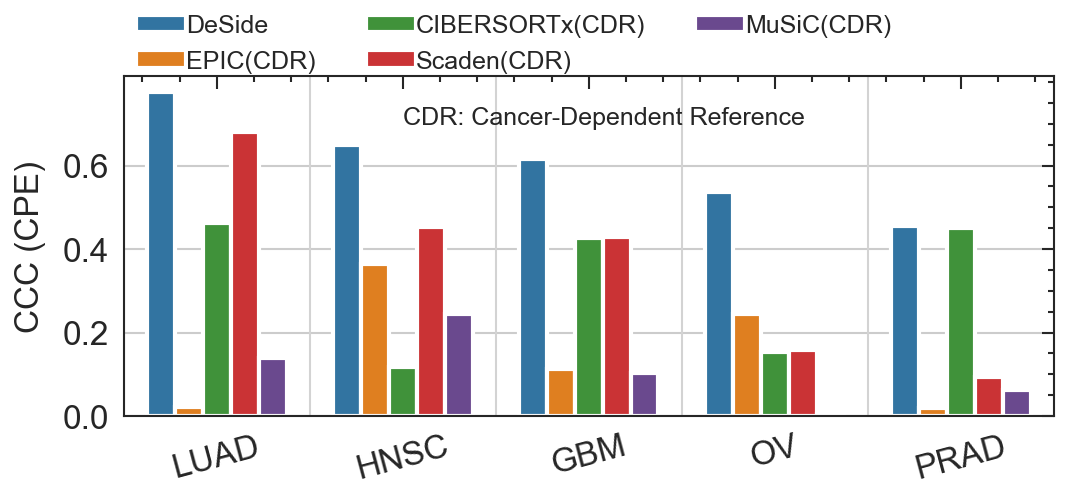

In [74]:
fig, axes = plt.subplots(figsize=(4, 1.5), nrows=1, ncols=1, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide', f'EPIC(CDR)', f'CIBERSORTx(CDR)', f'Scaden(CDR)', f'MuSiC(CDR)']
ref_cancer_types = ['LUAD', 'HNSC', 'GBM',  'OV', 'PRAD']
g1 = sns.barplot(data=ccc_all_ref_based_df, x='cancer_type', y='ccc', hue='algo', ax=axes, width=width, order=ref_cancer_types, palette=selected_colors, 
                 hue_order=m1)
# g1.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.22), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes.grid(axis='y')
for _x in range(5):
    axes.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(8)
# ax.legend(fontsize=6, loc='best')
axes.text(1., 0.7, 'CDR: Cancer-Dependent Reference', fontsize=6)
axes.set_yticks([0.0, 0.2, 0.4, 0.6])
axes.set_xlabel('')
axes.set_ylabel('CCC (CPE)', fontsize=8)
plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_5algo_ref_based.svg'), dpi=300)